Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1 external_states. See `.externals` for details.
Added 1500 recordings. See `.recordings` for details.
Added 1500 recordings. See `.recordings` for details.
{'axon_origin_dist': Array([18.24356166], dtype=float64), 'axon_theta': Array([0.99117253], dtype=float64), 'axon_phi': Array([2.08097765], dtype=float64), 'axon_spin_angle': Array([0.21696134], dtype=float64), 'radius': Array([2.03685219], dtype=float64), 'HH_gNa': Array([0.15183923], dtype=float64), 'HH_gK': Array([0.13813171], dtype=float64), 'axial_resistivity': Array([163.44849531], dtype=float64), 'total_length_um': Array([1500.], dtype=float64), 'segment_length_um': Array([1.],

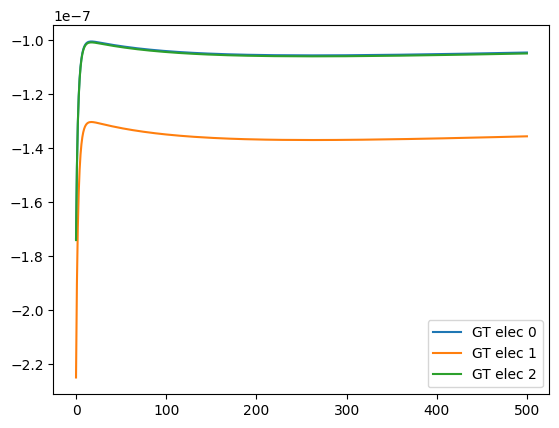

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1 external_states. See `.externals` for details.
Added 1500 recordings. See `.recordings` for details.
Added 1500 recordings. See `.recordings` for details.
{'HH_gK': Array([-1.44115448e-12], dtype=float64), 'HH_gNa': Array([7.16933816e-12], dtype=float64), 'axial_resistivity': Array([-2.47698176e-17], dtype=float64), 'axon_origin_dist': Array([-4.02331956e-12], dtype=float64), 'axon_phi': Array([-1.94403511e-12], dtype=float64), 'axon_spin_angle': Array([0.], dtype=float64), 'axon_theta': Array([0.], dtype=float64), 'radius': Array([2.92931187e-11], dtype=float64)}
Epoch 0, Loss: 0.000000, Grad Norm: 0.000000
{'HH_gK': Array([-1.4408549e

KeyboardInterrupt: 

In [ ]:

import pickle as pkl
import importlib

import straight_axon_model
importlib.reload(straight_axon_model)


gt_params, gt_ei = straight_axon_model.generate_random_gt_params_ei(seed=42)
print(gt_params)
print(gt_ei.shape)

import matplotlib.pyplot as plt
plt.plot(gt_ei[0, :], label='GT elec 0')
plt.plot(gt_ei[1, :], label='GT elec 1')
plt.plot(gt_ei[2, :], label='GT elec 2')
plt.legend()
plt.show()

#with open('./electrical_image_dataset/cell_41_ei.pkl', 'rb') as f:
#    ei_example = pkl.load(f)

#print(ei_example.shape)

trainer = straight_axon_model.StraightAxon()
final_params, losses = trainer.train(num_epochs=400, learning_rate=1e-1)


# trainer = model.StraightAxon()
# final_params, losses = trainer.train(data_point=None, num_epochs=400, learning_rate=1e-1)